# Review concurrent Equivital recordings

From qiosk files in a project file, extract recording per signal and a given interval of time, display values, realign data, and output csv of aligned concurrent measurements.

ALL TODO

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Definitions for data extraction

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex

In [3]:
%reload_ext autoreload

# Select project for review
Check the usual spot that QIOSK deposits files for data files detailing recordings

In [8]:
# location of the files when in one of the local project files
projectName = 'MusiciansPilot' # this needs to match the project folder name
path = "C:\\Users\\fourMs lab\\Documents\\Equivital\\ProjectData\\"+projectName+"\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"
#os.listdir(path)
# sep = '/'
sep = '\\'

In [9]:
df_datafiles = qex.qiosk_recordings(path,projectName,sep)
df_datafiles

Path is empty of DATA files.


[]

In [9]:
# key categories to structure of Qiosk output DATA files
print('Number of DATA files: '+ str(len(df_datafiles)))
print(df_datafiles['ID'].unique())
print(df_datafiles['Date'].unique())
print([df_datafiles['RecStart'].min(),df_datafiles['RecStart'].max()])
print([df_datafiles['RecEnd'].min(),df_datafiles['RecEnd'].max()])

Number of DATA files: 12
[3420755 3420456 3420426 3420427 5022138 5022126 3420415 5022139 5022050
 5022281 5022299 5022241]
[230127]
[Timestamp('2023-01-27 08:56:16+0000', tz='UTC'), Timestamp('2023-01-27 09:36:15+0000', tz='UTC')]
[Timestamp('2023-01-27 10:15:42+0000', tz='UTC'), Timestamp('2023-01-27 10:22:59+0000', tz='UTC')]


# Build a shared dataframe for concurrent recordings
Set the following:
- Measurement interval
- Signal
- Sample rate and timestamps in datetime and seconds (float)
- Interpolation framework


In [136]:
# signal File type and column name (multi sample)
signal_file_type = 'RESPACC'
sigName = 'Accelerometer'
sample_period = 0.04 # seconds 
interval_name = 'Synch_Session'
s_time = pd.to_datetime('2023-01-27 09:40:00+0000')
e_time = pd.to_datetime('2023-01-27 09:42:00+0000')
dur = (e_time - s_time).total_seconds()
time_s =  np.round(np.arange(0,dur,sample_period),3)

time_dt = s_time + pd.to_timedelta(time_s,unit='s')
df_sig = pd.DataFrame(index = time_dt)

In [137]:
s_files = df_datafiles.copy()
# recordings started before the recording interval
s_files=s_files.loc[s_files['RecStart']< s_time,:] 
# recordings ended after the recording interval
s_files=s_files.loc[s_files['RecEnd']> e_time,:] 
print(len(s_files))

12


In [138]:
# for most signals
for i,row in s_files.iterrows():
    dataFile = row['FullLoc']
    PartName = row['DevName']

    sigFileLoc = []
    matched = qex.matched_files(dataFile,path)
    for f in matched:
        if signal_file_type in f:
            sigFileLoc = f

    if sigFileLoc:
        V = pd.read_csv(sigFileLoc,skipinitialspace=True)
        V['DateTime'] = pd.to_datetime(V['DateTime'])
        sig_t = (V['DateTime'] - s_time).dt.total_seconds()
        cols = V.columns
        if sigName in cols:
            sig_v = V[sigName]
            f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
            new_sig = f(time_s)
            if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
                df_sig.loc[:,PartName] = new_sig

In [139]:
# for acceleration
for i,row in s_files.iterrows():
    dataFile = row['FullLoc']
    PartName = row['DevName']

    sigFileLoc = []
    matched = qex.matched_files(dataFile,path)
    for f in matched:
        if signal_file_type in f:
            sigFileLoc = f

    if sigFileLoc:
        V = pd.read_csv(sigFileLoc,skipinitialspace=True)
        V['DateTime'] = pd.to_datetime(V['DateTime'])
        sig_t = (V['DateTime'] - s_time).dt.total_seconds()
        cols = V.columns
        df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
        sig_v = np.sqrt(np.square(df.diff()).sum(axis=1))
        f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
        new_sig = f(time_s)
        if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
            df_sig.loc[:,PartName] = new_sig

<AxesSubplot:>

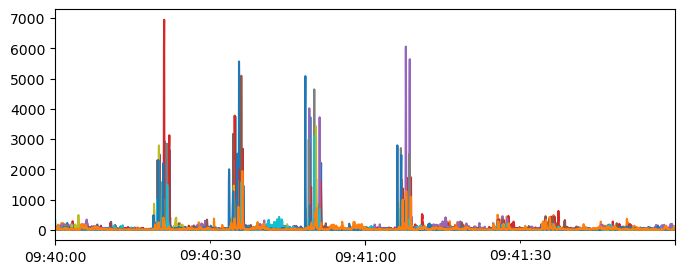

In [140]:
df_sig.plot(legend = False,figsize = [8,3])

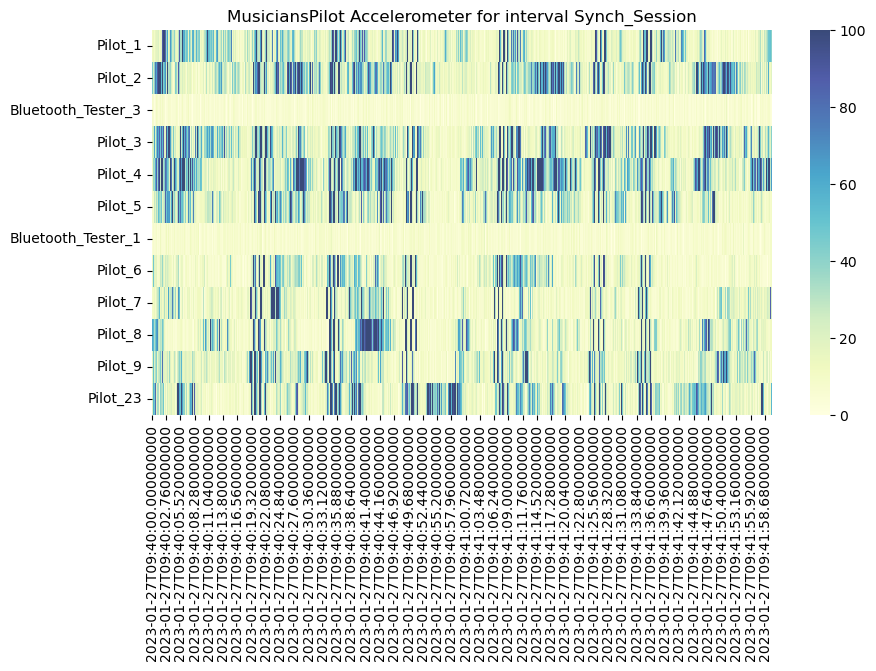

In [141]:
fig, (ax1) = plt.subplots(1, 1,figsize = [10,5])
chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=0, vmax=100, cbar=True, cmap="YlGnBu",alpha=0.8)
plt.title(projectName + ' ' + sigName + ' for interval ' + interval_name)
plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

NameError: name 'df_sig' is not defined

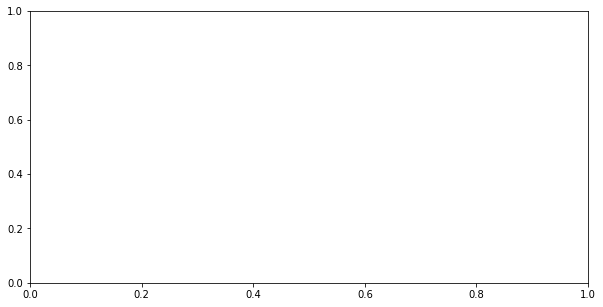

In [10]:
# for Breathing
fig, (ax1) = plt.subplots(1, 1,figsize = [10,5])
chart = sns.heatmap(data=df_sig.diff().transpose(),vmin=-20, vmax=20, ax=ax1,cbar=True,alpha=0.8)
# new_xticks = len(df_sig)*(key_times['CTime'])/(All_ACC.index[-1])
# ax1.set_xticks(new_xticks)
# ax1.set_xticklabels(key_times['event'])
# ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
plt.title(projectName + ' ' + sigName + ' for interval ' + interval_name)
# plt.ylabel(sigName)
plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

In [142]:
# save output 
df_sig.to_csv('./out_data/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.csv')